# TD9 - Nhận diện khuôn mặt một số ca sĩ Việt Nam 

# Mô tả

Trong TD này ta tiếp tục sử dụng OpenCV trên Python để nhận diện khuôn mặt một số ca sĩ Việt Nam thông qua hình ảnh chụp chính diện của họ thông qua Support Vector Machine.

Bố cục TD như sau
- Thông qua phương pháp Haar-Cascade, trích xuất khuôn mặt của ca sĩ trong hình ảnh.
- Cũng cùng phương pháp, trích xuất các thành phần của khuôn mặt. Trong phạm vi TD, ta chỉ trích xuất đôi mắt.
- Xây dựng các tập dữ liệu dựa trên khuôn mặt/đôi mắt của người trong ảnh
- Thực hiện huấn luyện và đánh giá với SVM tuyến tính và SVM đa thức
- Chọn các biến quan trọng để giảm số chiều bài toán.

Dữ liệu của bài toán được download tại đây
https://drive.google.com/drive/folders/14qdG6Txe0osUvTEbFjnxrqqfUk6dTsxR?usp=sharing

Trong đó bạn cần sử dụng các hình ảnh trong `RawData/face/format2`

Bạn cần hoàn thành các hàm/method trong file `SingerClassification.py`. File `Constants.py` được sử dụng để import cho `SingerClassification.py`, gồm các hằng số được định nghĩa trước có ý nghĩa như dưới đây.

In [1]:
# -*- coding: utf-8 -*-

# Thư mục chứa các hình ảnh gốc sẽ được sử dụng
RAW_IMAGE_FOLDER = "RawData/face/format2"

# Thư mục chứa các hình ảnh được copy, tập trung và đổi tên
IMAGE_FOLDER = "ImageFolder"

# Thư mục chứa các file text lưu trích xuất khuôn mặt, đôi mắt dưới dạng vector số, output của phần 1
TEXT_DATA_FOLDER = "TextData"

# Định dạng hình ảnh
EXTENSION = ".png"

# File Haar cascade của khuôn mặt
HAARCASCADE_FRONTALFACE_DEFAULT = "Configuration/haarcascade_frontalface_default.xml"

# File Haar cascade của đôi mắt
HAARCASCADE_EYE_DEFAULT = "Configuration/haarcascade_eye.xml"

# Hằng số kiểm tra xem khuôn mặt có được chụp ở tư thế trực diện không
# Khuôn mặt được xem là có tư thế trực diện nếu tâm mắt trái và tâm mắt phải có tung độ không cách nhau quá 3 pixel
HORIZONTAL_CHECK = 3

# File text lưu trích xuất khuôn mặt, đôi mắt dưới dạng vector số, output của phần 1
FACES_DATA = "TextData/Faces.csv"
EYES_DATA = "TextData/Eyes.csv"

# Chuẩn hoá tên các ca sĩ từ thư mục hình ảnh gốc
SINGER_NAME_DICTIONARY = {
    "bao thy" : "BaoThy",
    "chi pu": "ChiPu",
    "dam vinh hung": "DamVinhHung",
    "dan truong": "DanTruong",
    "ha anh tuan": "HaAnhTuan",
    "ho ngoc ha": "HoNgocHa",
    "huong tram": "HuongTram",
    "lam truong": "LamTruong",
    "my tam": "MyTam",
    "No phuoc thing": "NooPhuocThinh",
    "son tung": "SonTung",
    "tuan hung": "TuanHung"
}

# Đánh số thứ tự tên các ca sĩ
SINGER_INDEX_DICTIONARY = {
    "BaoThy": 0,
    "ChiPu": 1,
    "DamVinhHung": 2,
    "DanTruong": 3,
    "HaAnhTuan": 4,
    "HoNgocHa": 5,
    "HuongTram": 6,
    "LamTruong": 7,
    "MyTam": 8,
    "NooPhuocThinh": 9,
    "SonTung": 10,
    "TuanHung": 11
}

# Sau khi xử lí các hình ảnh và sắp xếp theo thứ tự ABC, các hình ảnh có thứ tự 0 đến 220 sẽ thuộc ca sĩ BaoThy
# v.v.
SINGER_IMAGE_RANGE = {
    "BaoThy": range(0, 221),
    "ChiPu": range(221, 521),
    "DamVinhHung": range(521, 676),
    "DanTruong": range(676, 811),
    "HaAnhTuan": range(811, 921),
    "HoNgocHa": range(921, 1109),
    "HuongTram": range(1109, 1327),
    "LamTruong": range(1327, 1407),
    "MyTam": range(1407, 1580),
    "NooPhuocThinh": range(1580, 1820),
    "SonTung": range(1820, 2020),
    "TuanHung": range(2020, 2226)
}

Đoạn code dưới đây import lời giải để minh hoạ.

In [2]:
from SingerClassification_Solution import *

## Phần 1 - Class `Face` - Trích xuất khuôn mặt và đôi mắt

### Bài 1. Copy và tập trung hình ảnh vào một thư mục

Thư mục chứa hình ảnh gốc nằm tại `RawData/face/format2` gồm 12 thư mục con như sau
<img src="F1.png"></img>

Tên các thư mục chính là các key của dict `SINGER_NAME_DICTIONARY` đã được định nghĩa trong `Constants.py`. Mỗi thư mục này chứa các hình ảnh ca sĩ có định dạng `.png` và kích thước `96 pixel x 96 pixel`. Tên các hình ảnh được đánh số không liên tục (vì có thể một số hình ảnh đã bị xoá do chất lượng không tốt hoặc ảnh không trực diện)

Để dễ làm việc về sau với các hình ảnh, ta muốn tập trung tất cả hình ảnh về một thư mục duy nhất và đặt lại tên để tên các hình ảnh có chỉ số được liên tục.

***Hãy viết hàm `prepareImageFolder(raw_image_folder, image_folder)` copy các hình ảnh trong tất cả các thư mục con (được đặt tên bằng các key trong `SINGER_NAME_DICTIONARY`) của `raw_image_folder` sang file `image_folder` và đặt lại tên các file dưới dạng `TenCaSi_Maso.png`, trong đó `TenCaSi` là value trong `SINGER_NAME_DICTIONARY`, các chỉ số bắt đầu từ 0. Ví dụ các hình ảnh từ thư mục `bao thy` sẽ có tên `BaoThy_0.png`, ..., `BaoThy_220.png`.***

Đoạn code sau giúp test hàm của bạn.

In [3]:
prepareImageFolder(RAW_IMAGE_FOLDER, IMAGE_FOLDER)

In [4]:
import pandas as pd
l = os.listdir(IMAGE_FOLDER) # Liệt kê thư mục mới
pd.DataFrame(l)

,0
0,BaoThy_0.png
1,BaoThy_1.png
2,BaoThy_10.png
3,BaoThy_100.png
4,BaoThy_101.png
5,BaoThy_102.png
6,BaoThy_103.png
7,BaoThy_104.png
8,BaoThy_105.png
9,BaoThy_106.png


Kết quả cần chứa 2227 hình ảnh với định dạng tên như liệt kê trên và như thư mục dưới đây:
<img src="F2.png"></img>

### Bài 2. Class `Face`

Ta xây dựng class `Face` sao cho mỗi instance của nó biểu diễn một hình ảnh, với trích xuất khuôn mặt và đôi mắt. Mỗi instance của class `Face` chứa các attribute sau:

- `image_path`: đường dẫn đến hình ảnh (ví dụ `ImageFolder/BaoThy_0.png`)
- `image_name`: tên hình ảnh, là tên file không chứa phần định dạng (ví dụ `BaoThy_0`)
- `gray_image`: numpy array biểu diễn hình ảnh dạng trắng đen (được gọi từ `cv2.imread(some_image, 0)`)
- `face_positions`, `eye_positions`: vị trí các khuôn mặt và con mắt trong hình ảnh (sẽ được tìm hiểu sau)
- `faces`, `eyes`: trích xuất các hình ảnh và con mắt, là một numpy array con của `gray_image`
- `normalized_faces`, `normalized_eyes`: numpy array biểu diễn khuôn mặt được chuẩn hoá về 64 x 64; con mắt được chuẩn hoá về 32 x 32.

Trước hết, ta xây dựng 3 attribute đầu tiên trong hàm `__init__`.

***Trong class `Face`, hãy viết method `__init__(self, image_path)` nhận đối số `image_path` là đường dẫn của hình ảnh và xây dựng instance thuộc class `Face` có các attributes `image_path`, `image_name`, `gray_image` như đã mô tả.***

Đoạn code dưới đây giúp test hàm của bạn.

In [5]:
face = Face(IMAGE_FOLDER + "/BaoThy_0.png")
print(face.gray_image)

[[204 204 203 ...  97  89  84]
 [205 204 204 ... 100  92  86]
 [205 205 205 ... 105  98  91]
 ...
 [217 216 217 ... 162 160 159]
 [215 215 215 ... 160 158 158]
 [215 215 214 ... 157 156 157]]


In [6]:
face.image_path

'ImageFolder/BaoThy_0.png'

In [7]:
face.image_name

'BaoThy_0'

### Bài 3. Vẽ hình bằng `matplotlib`

Phần này minh hoạ hình ảnh với `matplotlib`.

***Trong class `Face`, hãy viết method `draw(self, mode, index)` trong đó `mode` là một str, `index` là một int (mà ta chưa cần quan tâm trong bài này) sao cho nếu `mode` nhận giá trị `"full_gray"` thì khi gọi hàm `self.draw(mode = "full_gray")` sẽ trả lại dạng trắng đen của hình ảnh đang dùng.***

Đoạn code dưới đây giúp test hàm của bạn.

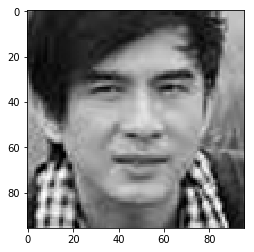

In [8]:
face = Face(IMAGE_FOLDER + "/DanTruong_10.png")
face.draw(mode = "full_gray")

### Bài 4. Xác định vị trí khuôn mặt và trích xuất khuôn mặt

Mặc dù các hình ảnh được xem là lấy khuôn mặt một cách trực diện, có những sự sai khác nhất định về vị trí tương đối của khuôn mặt trong hình ảnh, cũng như một số khuôn mặt không thực sự trực diện, chẳng hạn như hình dưới đây.

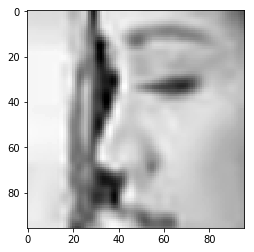

In [9]:
face = Face(IMAGE_FOLDER + "/BaoThy_0.png")
face.draw(mode = "full_gray")

Vì vậy, ta sử dụng phương pháp Haar Feature-based Cascade để "trích xuất" gương mặt theo phương pháp tương đồng giữa 1 zone hình ảnh với thác Haar tương ứng. Bạn có thể xem chi tiết về phương pháp và cách dùng ở đây: https://docs.opencv.org/2.4/modules/objdetect/doc/cascade_classification.html#cascadeclassifier-detectmultiscale

***Trong class `Face`, hãy viết method `detectFaces(self)` tìm tất cả các bộ `(x, y, w, h)` xác định vị trí khuôn mặt như output của `detectMultiScale` trong cv2 (tức `(x, y), (x + w, y), (x, y + h), (x + w, y + h)` sẽ là toạ độ 4 đỉnh của vùng khuôn mặt) và gán vào attribute `self.face_positions` array tất cả các bộ 4 tìm được. Hình ảnh xác định được `N` khuôn mặt thì array sẽ có chiều `N x 4`***.

Bạn có thể sử dụng `scaleFactor = Face.HAAR_SCALE_FACTOR, minNeighbors = Face.HAAR_MIN_NEIGHBORS, minSize = Face.HAAR_MIN_SIZE` cho hàm `detectMultiScale` và file `Face.HAARCASCADE_FRONTALFACE` cho cascade của khuôn mặt.

Đoạn code dưới đây giúp test hàm của bạn.

In [10]:
face = Face(IMAGE_FOLDER + "/BaoThy_10.png") # Cần ra 1 khuôn mặt, array có dạng 4 x 1
face.face_positions

array([[11,  5, 74, 74]], dtype=int32)

In [11]:
face = Face(IMAGE_FOLDER + "/BaoThy_0.png") # Cần ra 0 khuôn mặt, array có dạng 4 x 0 = 0
face.face_positions

()

***Tiếp theo, cũng trong method `detectFaces(self)`, gán các numpy array con của `self.gray_image` biểu diễn khuôn mặt tương ứng vào attribute `faces` dưới dạng 1 list. Hình ảnh xác định được bao nhiêu khuôn mặt thì list sẽ có bấy nhiêu phần tử, mỗi phần tử là một array.***

Đoạn code dưới đây giúp test hàm của bạn.

In [12]:
face = Face(IMAGE_FOLDER + "/BaoThy_10.png") 
face.faces # List chứa 1 phần tử: 1 array 74 x 74

[array([[ 29,  32,  26, ...,  99, 110, 113],
        [ 29,  31,  27, ...,  99, 114, 103],
        [ 27,  28,  29, ..., 104, 108, 107],
        ...,
        [ 15,  33,  26, ...,  14,  16,  22],
        [ 28,  44,  32, ...,  13,  15,  20],
        [ 55,  55,  46, ...,  13,  14,  18]], dtype=uint8)]

In [13]:
face = Face(IMAGE_FOLDER + "/BaoThy_0.png") 
face.faces # List chứa 0 phần tử

[]

***Cuối cùng, thêm vào method `draw(self, mode, index)` đã viết ở bài 3 để khi `mode` nhận giá trị `"face"` thì kết quả nhận được là biểu diễn hình ảnh của trích xuất khuôn mặt thứ `index` trong list `self.faces`, còn nếu `mode` nhận giá trị là `face_marked` thì kết quả là toàn bộ hình ảnh, nhưng phần khuôn mặt được trích xuất được đánh dấu (chẳng hạn bằng cách đóng khung)***

Đoạn code dưới đây lặp lại bài 3 khi `mode="full_gray"`

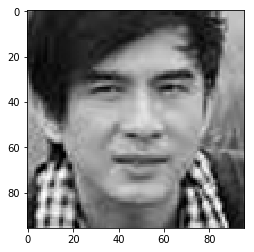

In [14]:
face = Face(IMAGE_FOLDER + "/DanTruong_10.png") 
face.draw(mode = "full_gray") 

Đoạn code dưới đây minh hoạ khi `mode="face"`

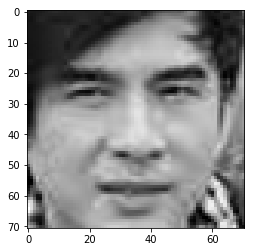

In [15]:
face = Face(IMAGE_FOLDER + "/DanTruong_10.png") 
face.draw(mode = "face", index = 0) 

Đoạn code dưới đây đánh dấu (đóng khung) khuôn mặt trên hình gốc

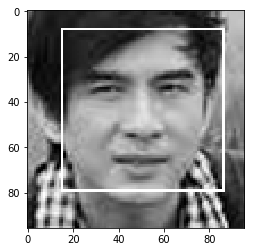

In [16]:
face = Face(IMAGE_FOLDER + "/DanTruong_10.png") 
face.draw(mode = "face_marked", index = 0) 

### Bài 5 - Chuẩn hoá kích thước khuôn mặt

***Áp dụng `cv2.resize()` đã thực hiện ở các TD trước, chuẩn hoá kích thước các khuôn mặt trong list `self.faces` về 64 x 64 pixel và lưu chúng vào list `self.normalized_faces` trong class `Face`.***

***Tiếp tục viết thêm vào method `draw(self, mode, index)` để khi `mode` nhận giá trị `"normalized_face"` thì nhận được trích xuất khuôn mặt được vẽ bởi matplotlib với kích thước 64 x 64.*** 

In [17]:
face = Face(IMAGE_FOLDER + "/DanTruong_10.png") 
face.normalized_faces

[array([[ 28,  25,  25, ...,  37,  47, 102],
        [ 23,  22,  25, ...,  40,  44,  78],
        [ 20,  20,  26, ...,  45,  50,  64],
        ...,
        [117,  66,  40, ...,  75,  25,  57],
        [130, 101,  68, ...,  99,  21,  41],
        [171, 147, 112, ..., 147,  35,  15]], dtype=uint8)]

In [18]:
face.normalized_faces[0].shape # Kết quả là 64 x 64

(64, 64)

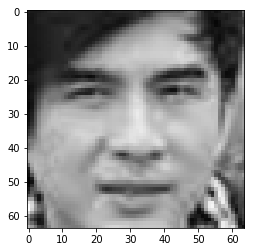

In [19]:
face = Face(IMAGE_FOLDER + "/DanTruong_10.png") 
face.draw(mode = "normalized_face", index = 0) # Kết quả là 1 hình có kích thước 64 pixel x 64 pixel

### Bài 6 - Xác định vị trí mắt và trích xuất mắt

***Trong class `Face`, hãy viết method `detectFaces(self)` tìm tất cả các bộ `(i, (x, y, w, h))` xác định vị trí mắt, trong đó `i` là số thứ tự khuôn mặt chứa mắt trong `self.faces`; còn `(x, y, w, h)` như output của `detectMultiScale` trong cv2 (tức `(x, y), (x + w, y), (x, y + h), (x + w, y + h)` sẽ là toạ độ 4 đỉnh của vùng mắt); và gán list tất cả các bộ `(i, (x, y, w, h))` tìm được vào attribute `self.eye_positions`. Hình ảnh xác định được bao nhiêu con mắt thì `self.eye_positions` sẽ là list sẽ có độ dài bấy nhiêu***.

Ví dụ với hình ảnh `DanTruong_10`, chỉ xác định được 1 mắt.

In [20]:
face = Face(IMAGE_FOLDER + "/DanTruong_10.png")
face.eye_positions

[(0, array([40, 13, 22, 22], dtype=int32))]

Với hình ảnh `DanTruong_4`, chỉ xác định được 2 mắt.

In [21]:
face = Face(IMAGE_FOLDER + "/DanTruong_4.png")
face.eye_positions

[(0, array([37, 15, 22, 22], dtype=int32)),
 (0, array([ 9, 14, 24, 24], dtype=int32))]

Với hình ảnh `DanTruong_1`, thậm chí xác định được nhiều "mắt" hơn

In [22]:
face = Face(IMAGE_FOLDER + "/DanTruong_4.png")
face.eye_positions

[(0, array([37, 15, 22, 22], dtype=int32)),
 (0, array([ 9, 14, 24, 24], dtype=int32))]

***Tiếp theo, cũng trong method `detectFaces(self)`, gán các bộ `(i, X)` vào `self.eyes` trong đó `X` là array con tương ứng các mắt đã xác định được.***

Các đoạn code dưới đây giúp test hàm của bạn

In [23]:
face = Face(IMAGE_FOLDER + "/DanTruong_4.png")
face.eyes # Cần là list 2 phần tử, mỗi phần tử là 1 bộ 1 số nguyên và 1 array)

[(0, array([[214, 216, 217, 217, 216, 214, 213, 213, 214, 213, 209, 210, 211,
          213, 214, 213, 213, 210, 208, 209, 195, 183],
         [218, 219, 218, 218, 216, 213, 209, 204, 209, 225, 209, 198, 204,
          201, 200, 197, 193, 195, 195, 194, 177, 172],
         [216, 213, 210, 210, 211, 212, 211, 207, 206, 211, 207, 192, 180,
          167, 166, 167, 155, 160, 160, 146, 131, 140],
         [210, 206, 203, 204, 206, 205, 200, 195, 182, 171, 177, 166, 142,
          122, 130, 143, 136, 121, 112, 105,  98, 105],
         [199, 198, 199, 200, 197, 185, 173, 165, 147, 124, 112, 103,  94,
           87,  89, 103, 107,  90,  80,  84,  78,  74],
         [191, 194, 197, 195, 184, 163, 140, 127, 115,  96,  67,  66,  72,
           70,  63,  72,  89,  82,  80,  78,  62,  47],
         [190, 195, 195, 185, 167, 141, 120, 107, 101,  95,  82,  89,  91,
           82,  70,  74,  87,  81,  74,  72,  75,  66],
         [194, 195, 187, 169, 148, 130, 121, 120, 120, 125, 137, 145, 132,
     

***Cuối cùng, thêm vào method `draw(self, mode, index)` đã viết ở bài 3 để khi `mode` nhận giá trị `"eye"` thì kết quả nhận được là biểu diễn hình ảnh của trích xuất mắt thứ `index` trong list `self.eyes`, còn nếu `mode` nhận giá trị là `eye_marked` thì kết quả là toàn bộ hình ảnh, nhưng phần mắt được trích xuất được đánh dấu (chẳng hạn bằng cách đóng khung)***

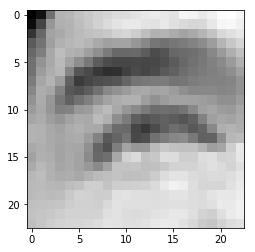

In [24]:
face = Face(IMAGE_FOLDER + "/DanTruong_1.png")
face.draw(mode="eye", index = 0)

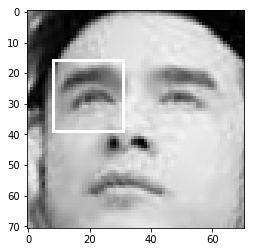

In [25]:
face = Face(IMAGE_FOLDER + "/DanTruong_1.png")
face.draw(mode="eye_marked", index = 1)

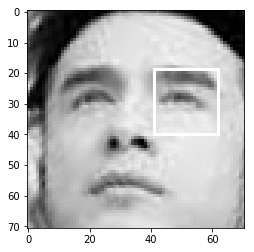

In [26]:
face = Face(IMAGE_FOLDER + "/DanTruong_1.png")
face.draw(mode="eye_marked", index = 2) # Trường hợp phát hiện nhiều mắt trong cùng 1 zone

### Bài 7 - Chuẩn hoá kích thước mắt

***Áp dụng `cv2.resize()` đã thực hiện ở các TD trước, chuẩn hoá kích thước các khuôn mặt trong list `self.eyes` về 32 x 32 pixel và lưu chúng vào attribute `self.normalized_eyes` dưới dạng 1 list `(i, X)` như `self.eyes`, nhưng `X` là các numpy array 32 x 32.***

***Tiếp tục viết thêm vào method `draw(self, mode, index)` để khi `mode` nhận giá trị `"normalized_eye"` thì nhận được trích xuất mắt thứ `index` được vẽ bởi matplotlib với kích thước 32 x 32.*** 

In [27]:
face = Face(IMAGE_FOLDER + "/DanTruong_4.png")
face.normalized_eyes

[array([[214, 215, 216, ..., 198, 189, 183],
        [216, 217, 217, ..., 189, 182, 177],
        [218, 217, 217, ..., 170, 166, 165],
        ...,
        [212, 208, 202, ..., 205, 203, 201],
        [213, 208, 202, ..., 202, 200, 199],
        [215, 209, 202, ..., 201, 199, 197]], dtype=uint8),
 array([[173, 172, 177, ..., 205, 205, 205],
        [175, 174, 179, ..., 210, 210, 212],
        [180, 179, 181, ..., 211, 213, 217],
        ...,
        [200, 200, 200, ..., 188, 190, 193],
        [201, 201, 200, ..., 187, 190, 192],
        [200, 201, 201, ..., 194, 195, 195]], dtype=uint8)]

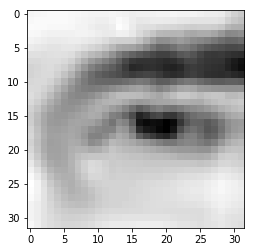

In [28]:
face.draw(mode = "normalized_eye", index = 0) # Mắt phải, kích thước 32 x 32

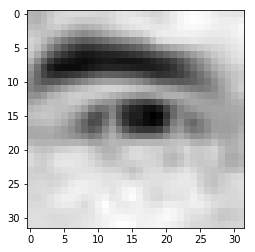

In [29]:
face.draw(mode = "normalized_eye", index = 1) # Mắt trái, kích thước 32 x 32

### Bài 8 - Chuyển các khuôn mặt thành vector

Ta muốn lưu các khuôn mặt dưới dạng các vector số vào một file dữ liệu sao cho mỗi khuôn mặt ứng với một dòng của file, tức toạ độ của một vector có số chiều 4096 (=64 x 64) cách nhau bằng dấu phẩy; sau đó là một số nguyên cho biết chỉ số của ca sĩ trong từ điển `SINGER_INDEX_DICTIONARY` và tên hình ảnh tương ứng. Ví dụ file có dạng sau.

<img src="F3.png" width = 1000></img>

Nếu quan sát file bằng pandas, ta dễ thấy cấu trúc file.

In [30]:
pd.read_csv("TextData/Faces.csv", sep=",", header=None) #Faces.csv là ví dụ utput của bài

,0,1,2,3,4,5,6,7,8,9,...,4088,4089,4090,4091,4092,4093,4094,4095,4096,4097
0,155,140,109,62,27,26,28,30,52,83,...,114,103,76,50,56,61,89,171,2,DamVinhHung_1
1,102,10,4,6,8,4,2,8,29,51,...,186,163,162,203,194,207,205,214,2,DamVinhHung_10
2,30,30,38,50,60,59,55,63,80,90,...,61,63,60,50,46,46,49,52,2,DamVinhHung_100
3,47,76,118,143,148,152,158,163,168,171,...,36,56,65,65,66,60,62,75,2,DamVinhHung_101
4,32,21,11,3,6,33,76,106,128,133,...,112,77,26,9,19,19,17,13,2,DamVinhHung_102
5,203,209,211,210,209,208,209,212,208,191,...,183,187,187,183,184,186,186,185,2,DamVinhHung_103
6,214,213,219,213,188,143,93,58,57,66,...,175,175,174,171,170,168,166,164,2,DamVinhHung_104
7,79,90,93,108,125,132,131,132,135,141,...,249,243,237,242,244,241,240,242,2,DamVinhHung_105
8,66,71,76,81,86,92,98,105,111,115,...,165,163,160,159,161,164,166,166,2,DamVinhHung_106
9,133,138,145,150,152,152,151,149,150,154,...,68,61,63,66,67,65,61,58,2,DamVinhHung_107


Để giới hạn thời gian, ta dùng thêm một tham số `index_list` dạng list, chẳng hạn nếu `index_list = [0, 1, 3, 4, 5]` thì ta chỉ xử lí 5 hình ảnh có số thứ tự tương ứng.

***Hãy viết hàm `transformImagesToFacesTable(source_folder, destination_folder, destination_data_file, index_list)` (ngoài class `Face`) đọc các hình ảnh có số thứ tự trong list `index_list` trong thư mục `source_folder`, rồi lưu dữ liệu vào file `destination_data_file` nằm trong thư mục `destination_folder` như mô tả trên (mỗi khuôn mặt 1 dòng gồm 4096 toạ độ, 1 chỉ số ca sĩ, 1 tên file cách nhau bởi các dấu phẩy).***

Bạn có thể test bằng đoạn code dưới đây sau đó kiểm tra cấu trúc file `output.csv`

In [31]:
transformImagesToFacesTable(IMAGE_FOLDER, TEXT_DATA_FOLDER, "TextData/output.csv", range(20))
pd.read_csv('TextData/output.csv', sep=',', header=None)
#Dòng '10 files processed' không quan trọng, nó được viết để theo dõi tiến độ chạy của chương trình 

10 files processed.
20 files processed.


,0,1,2,3,4,5,6,7,8,9,...,4088,4089,4090,4091,4092,4093,4094,4095,4096,4097
0,70,78,86,88,80,80,74,67,75,59,...,16,14,11,30,83,142,198,191,0,BaoThy_1
1,29,30,27,33,33,42,63,62,70,76,...,8,8,9,10,11,13,14,18,0,BaoThy_10
2,72,76,80,83,87,90,97,103,111,115,...,220,220,220,220,220,221,221,221,0,BaoThy_100
3,74,76,73,65,73,95,100,93,91,88,...,231,244,251,250,251,253,255,255,0,BaoThy_101
4,27,30,33,36,24,8,25,17,21,26,...,20,23,30,37,38,36,42,51,0,BaoThy_102
5,106,64,79,102,107,94,94,106,114,107,...,60,58,50,61,71,75,76,74,0,BaoThy_103
6,88,73,64,68,67,58,45,37,36,40,...,64,65,65,68,69,70,72,76,0,BaoThy_104
7,135,129,130,135,144,155,169,178,180,186,...,57,53,53,57,65,70,70,68,0,BaoThy_105
8,153,149,151,151,150,152,153,154,157,159,...,98,99,99,100,100,101,101,102,0,BaoThy_106
9,67,88,111,107,101,88,74,86,89,104,...,0,0,0,0,0,0,0,0,0,BaoThy_107


Ta thấy hình ảnh `BaoThy_0` không xuất hiện trong file output vì không xác định được khuôn mặt. Do đó khi process 20 hình ảnh, ta chỉ thu được 19 khuôn mặt.

### Bài 9 - Chuyển các đôi mắt thành vector

Ta muốn lưu các đôi mắt dưới dạng các vector số vào một file dữ liệu sao cho mỗi đôi mắt ứng với một dòng của file, tức toạ độ của một vector có số chiều 2048 (=2 x 32 x 32) cách nhau bằng dấu phẩy; sau đó là một số nguyên cho biết chỉ số của ca sĩ trong từ điển `SINGER_INDEX_DICTIONARY` và tên hình ảnh tương ứng. Ví dụ file có dạng sau. Điều này chỉ thực hiện được khi hình ảnh xác định được cả 2 mắt của người trong ảnh.

Muốn vậy, ta phải tìm các ảnh sao cho attribute `self.normalized_eyes` gồm ít nhất 2 phần tử. Thông thường, hình ảnh không rõ sẽ dẫn đến nhầm lẫn miệng-mắt. Nếu các phần tử tìm được đều là mắt và được tìm theo thứ tự từ trái sang phải của hình. Như vậy, nếu cả 2 mắt đều được tìm ra thì `self.normalized_eyes[0]` sẽ là mắt phải, và `self.normalized_eyes[-1]` sẽ là mắt trái của người trong hình. Hai mắt này được xem là "chất lượng tốt" nếu các tiêu chuẩn sau được thoả mãn:

- Hoành độ 2 tâm hình chữ nhật chứa 2 mắt trong ảnh không cách nhau quá `HORIZONTAL_CHECK = 3` pixel (nếu lớn hơn, cho thấy mặt không được chụp thẳng hoặc 1 thành phần khác của khuôn mặt (như miệng) đã bị lẫn vào.)

- Tung độ tâm hình chữ nhật chứa 2 mắt trong ảnh phải ít nhất lớn hơn `VERTICAL_CHECK = 10` pixel (nếu nhỏ hơn, nó cho thấy `self.normalized_eyes[0]` và `self.normalized_eyes[-1]` là 1 mắt được tìm ra 2 lần, còn 1 mắt không tìm ra được).

***Hãy viết hàm `transformImagesToEyesTable(source_folder, destination_folder, destination_data_file, index_list)` (ngoài class `Face`) đọc các hình ảnh có số thứ tự trong list `index_list` trong thư mục `source_folder`, rồi lưu dữ liệu vào file `destination_data_file` nằm trong thư mục `destination_folder` như mô tả trên (mỗi khuôn mặt 1 dòng gồm 2048 toạ độ trong đó 1024 của mắt phải, theo bởi 1024 của mắt trái, rồi 1 chỉ số ca sĩ, 1 tên file cách nhau bởi các dấu phẩy). Nếu ít nhất một hai điều kiện kiểm tra "chất lượng tốt" trên không được thoả mãn, loại bỏ hình ảnh khỏi tập dữ liệu.***

Đoạn code dưới đây giúp kiểm tra hàm của bạn.

In [32]:
transformImagesToEyesTable(IMAGE_FOLDER, TEXT_DATA_FOLDER, "TextData/output2.csv", range(20))
pd.read_csv('TextData/output2.csv', sep=',', header=None)

10 files processed.
20 files processed.


,0,1,2,3,4,5,6,7,8,9,...,2040,2041,2042,2043,2044,2045,2046,2047,2048,2049
0,190,189,188,184,177,170,163,156,150,147,...,211,213,216,217,219,219,218,218,0,BaoThy_100
1,94,93,89,83,74,75,81,85,85,85,...,230,223,223,224,226,227,224,221,0,BaoThy_101
2,201,199,198,198,201,205,210,215,218,220,...,181,177,174,171,167,162,154,147,0,BaoThy_104
3,209,213,215,213,208,205,199,193,186,174,...,178,162,143,120,97,76,67,63,0,BaoThy_105
4,181,182,183,183,181,181,183,187,190,194,...,165,162,158,155,152,150,148,146,0,BaoThy_106
5,111,113,115,117,115,113,110,107,104,103,...,169,167,163,160,158,159,157,154,0,BaoThy_108
6,12,31,56,78,88,91,84,82,84,95,...,221,222,222,219,216,217,219,219,0,BaoThy_11
7,48,51,56,67,80,94,106,112,110,104,...,207,206,203,199,196,197,202,207,0,BaoThy_110
8,193,190,188,188,187,187,187,187,188,187,...,185,182,179,178,177,176,175,172,0,BaoThy_113
9,140,144,149,153,157,160,168,169,165,159,...,203,203,202,199,194,189,183,177,0,BaoThy_115


Kết quả cho thấy trong 20 hình ảnh đầu tiên của ca sí BaoThy, chỉ có 10 hình ảnh chất lượng tốt (tìm được 2 mắt)

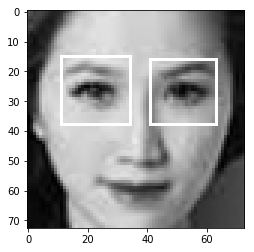

In [33]:
# Ví dụ 1 ảnh tốt
face = Face('ImageFolder/BaoThy_104.png')
face.draw('eye_marked', 0)
face.draw('eye_marked', -1)

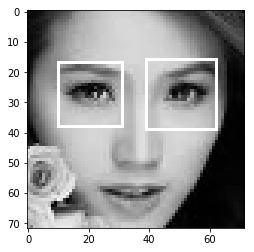

In [34]:
# Ví dụ 1 ảnh tốt khác
face = Face('ImageFolder/BaoThy_115.png')
face.draw('eye_marked', 0)
face.draw('eye_marked', -1)

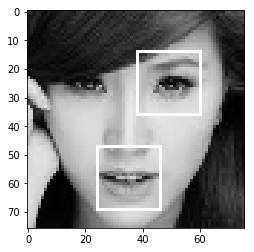

In [35]:
# Ví dụ 1 ảnh xấu
face = Face('ImageFolder/BaoThy_102.png')
face.draw('eye_marked', 0)
face.draw('eye_marked', -1)

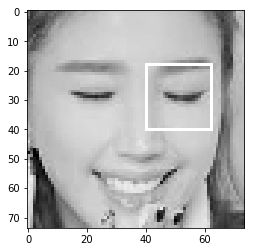

In [36]:
# 1 ảnh "xấu" khác. Trong code của lời giải xử lí nếu index > len(self.normalized_eyes) thì in ra thông báo "Chỉ có ... mắt" được tìm ra"
face = Face('ImageFolder/BaoThy_103.png')
face.draw('eye_marked', 0)
face.draw('eye_marked', -1)

## Phần 2 - Xây dựng class DataSet

### Bài 10 - Class `DataSet`

Ta xây dựng một class `DataSet` từ dữ liệu đã được lưu ở file output của các bài 8, 9. Mỗi instance của class này có các attribute như sau:

- `X`: một array `N x d` với mỗi dòng là một vector (số chiều bằng `d`=4096 hoặc 2048 tuỳ theo tập dữ liệu lấy từ mặt hay mắt; số chiều có thể giảm để nhỏ hơn 4096, 2048 ở các bài tiếp theo; `N` là số dòng trong file dữ liệu)

- `y`: một array có độ dài `N` tương ứng với lớp mà các khuôn mặt/đôi mắt thuộc về. Chỉ số của lớp chính là chỉ số của ca sĩ.

- `names`: một array có độ dài `N` tương ứng với tên hình ảnh.

***Trong class `DataSet`, viết method `__init__(self, data_file, selected_columns = None)` trong đó `data_file` là đường dẫn đến file dữ liệu (có dạng như output của bài 8 hoặc 9), `select_columns` là một list các chỉ số toạ độ mà ta chưa cần quan tâm ở bài này; sau đó xây dựng các attribute `X`, `y` và `names` như mô tả.***

Với file `output.csv` như đã thực hiện ở bài 8, bạn có thể kiểm tra hàm đã viết với đoạn code sau.

In [37]:
dataSet = DataSet("TextData/output.csv")
dataSet.X

array([[ 70,  78,  86, ..., 142, 198, 191],
       [ 29,  30,  27, ...,  13,  14,  18],
       [ 72,  76,  80, ..., 221, 221, 221],
       ...,
       [104, 101,  94, ...,  46,  60,  81],
       [134, 134, 134, ...,  33,  38,  40],
       [ 12,  12,  11, ...,   7,   4,   4]], dtype=int64)

In [38]:
dataSet.X.shape # Một array 19 x 4096

(19, 4096)

In [39]:
dataSet.y, dataSet.names

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       dtype=int64),
 array(['BaoThy_1', 'BaoThy_10', 'BaoThy_100', 'BaoThy_101', 'BaoThy_102',
        'BaoThy_103', 'BaoThy_104', 'BaoThy_105', 'BaoThy_106',
        'BaoThy_107', 'BaoThy_108', 'BaoThy_109', 'BaoThy_11',
        'BaoThy_110', 'BaoThy_111', 'BaoThy_112', 'BaoThy_113',
        'BaoThy_114', 'BaoThy_115'], dtype=object))

**Chú ý:** Sau khi viết xong các hàm ở bài 8, 9, 10, để xây dựng data set gồm tất cả các khuôn mặt xác định được từ các hình ảnh của chẳng hạn 2 ca sĩ MyTam và DanTruong, bạn có thể dùng đoạn code sau.

In [42]:
from itertools import chain
singers = ["MyTam", "DanTruong"]

# Lưu vào file MyTam_vs_DanTruong.csv
transformImagesToFacesTable(IMAGE_FOLDER, TEXT_DATA_FOLDER, "TextData/MyTam_vs_DanTruong.csv", chain.from_iterable([SINGER_IMAGE_RANGE[s] for s in singers]))

10 files processed.
20 files processed.
30 files processed.
40 files processed.
50 files processed.
60 files processed.
70 files processed.
80 files processed.
90 files processed.
100 files processed.
110 files processed.
120 files processed.
130 files processed.
140 files processed.
150 files processed.
160 files processed.
170 files processed.
180 files processed.
190 files processed.
200 files processed.
210 files processed.
220 files processed.
230 files processed.
240 files processed.
250 files processed.
260 files processed.
270 files processed.
280 files processed.
290 files processed.
300 files processed.


In [43]:
dataSet = DataSet("TextData/MyTam_vs_DanTruong.csv")
dataSet.X

array([[ 95,  91,  82, ...,  11,  18,  33],
       [164, 164, 143, ...,  31,  36,  39],
       [128, 127, 126, ..., 199, 202, 209],
       ...,
       [ 23,  20,  14, ...,  87,  59,  34],
       [ 30,  28,   7, ..., 247, 224, 192],
       [ 13,  13,  16, ..., 156, 166,  96]], dtype=int64)

In [44]:
dataSet.X.shape # Kết quả cho thấy có 303 khuôn mặt được xác định

(303, 4096)

In [45]:
dataSet.y

array([8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

In [46]:
dataSet.names

array(['MyTam_0', 'MyTam_1', 'MyTam_10', 'MyTam_100', 'MyTam_101',
       'MyTam_102', 'MyTam_103', 'MyTam_105', 'MyTam_106', 'MyTam_107',
       'MyTam_108', 'MyTam_109', 'MyTam_11', 'MyTam_110', 'MyTam_111',
       'MyTam_112', 'MyTam_113', 'MyTam_114', 'MyTam_115', 'MyTam_116',
       'MyTam_117', 'MyTam_118', 'MyTam_119', 'MyTam_12', 'MyTam_120',
       'MyTam_121', 'MyTam_122', 'MyTam_123', 'MyTam_124', 'MyTam_125',
       'MyTam_126', 'MyTam_127', 'MyTam_128', 'MyTam_129', 'MyTam_13',
       'MyTam_130', 'MyTam_131', 'MyTam_132', 'MyTam_133', 'MyTam_134',
       'MyTam_135', 'MyTam_136', 'MyTam_137', 'MyTam_138', 'MyTam_139',
       'MyTam_14', 'MyTam_140', 'MyTam_141', 'MyTam_142', 'MyTam_143',
       'MyTam_144', 'MyTam_145', 'MyTam_146', 'MyTam_147', 'MyTam_148',
       'MyTam_149', 'MyTam_15', 'MyTam_150', 'MyTam_151', 'MyTam_152',
       'MyTam_153', 'MyTam_154', 'MyTam_155', 'MyTam_156', 'MyTam_157',
       'MyTam_158', 'MyTam_159', 'MyTam_16', 'MyTam_160', 'MyTam_161',
   

### Bài 11. Chia thành 2 phần train/test

***Trong class `DataSet`, viết method `trainTestSplit(self, test_size)` chia các array `X`, `y`, `names` thành 2 phần được gán cho `X_train`, `X_test`, `y_train`, `y_test`, `names_train`, `names_test` sao cho tỉ lệ các dòng dữ liệu của phần test bằng `test_size` (nằm trong (0, 1)). Bạn có thể dùng `model_selection.train_test_split` của scikit-learn và dùng tham số `random_state` của class này để cố định tập train và test.***

Đoạn code dưới đây giúp test hàm của bạn.

In [48]:
dataSet = DataSet("TextData/MyTam_vs_DanTruong.csv")
dataSet.trainTestSplit(test_size = 0.5)

In [49]:
dataSet.X_train

array([[161, 147, 134, ...,  95,  95, 101],
       [ 67,  78,  75, ...,   0,   0,   0],
       [ 39,  50,  34, ...,  22,  35,  39],
       ...,
       [ 72,  85, 103, ...,  48,  43,  45],
       [167, 147, 131, ..., 115, 119, 124],
       [ 28,  25,  25, ..., 147,  35,  15]], dtype=int64)

In [50]:
dataSet.X_train.shape # 151 dòng được dùng để train

(151, 4096)

In [53]:
dataSet.y_train, dataSet.names_train # Các dòng được chọn ngẫu nhiên ứng với ca sĩ MyTam và DanTruong

(array([8, 3, 3, 8, 3, 3, 3, 8, 8, 8, 3, 8, 3, 8, 8, 3, 8, 8, 8, 8, 8, 3,
        3, 8, 3, 8, 3, 3, 8, 3, 3, 8, 8, 8, 3, 3, 8, 8, 3, 8, 3, 8, 3, 8,
        8, 3, 8, 8, 8, 3, 8, 3, 3, 3, 8, 8, 8, 8, 3, 8, 3, 8, 3, 8, 8, 8,
        3, 8, 3, 8, 3, 3, 3, 8, 8, 3, 8, 3, 8, 8, 3, 3, 8, 3, 8, 8, 3, 8,
        8, 8, 8, 8, 8, 3, 8, 8, 8, 3, 3, 8, 8, 8, 8, 8, 3, 8, 8, 3, 8, 8,
        3, 8, 8, 3, 3, 8, 8, 8, 3, 3, 3, 8, 3, 3, 8, 3, 3, 8, 3, 8, 8, 8,
        3, 3, 3, 8, 3, 8, 8, 8, 3, 3, 3, 3, 8, 3, 3, 3, 8, 8, 3],
       dtype=int64),
 array(['MyTam_169', 'DanTruong_78', 'DanTruong_117', 'MyTam_116',
        'DanTruong_57', 'DanTruong_37', 'DanTruong_68', 'MyTam_171',
        'MyTam_145', 'MyTam_10', 'DanTruong_40', 'MyTam_39',
        'DanTruong_61', 'MyTam_22', 'MyTam_108', 'DanTruong_27',
        'MyTam_151', 'MyTam_136', 'MyTam_111', 'MyTam_86', 'MyTam_144',
        'DanTruong_19', 'DanTruong_39', 'MyTam_56', 'DanTruong_23',
        'MyTam_155', 'DanTruong_118', 'DanTruong_32', 'MyTam_62',
 

### Bài 12. Training

***Trong class `DataSet`, viết method `train(self, model)` nhận đối số `model` là một Classifier của `scikit-learn` (như `SVC` hay `LogisticRegression` v.v...), train model này với `X_train` và `y_train`, và trả lại `model` đã train.***

Sau khi train, bạn cần tự viết một đoạn code để test hàm này với Support Vector Machine với linear kernel. Đoạn code dưới đây chỉ dùng để tham khảo, bạn cần viết đoạn code tương tự như vậy.

In [4]:
from sklearn.svm import SVC
dataSet = DataSet("TextData/MyTam_vs_DanTruong.csv")
dataSet.trainTestSplit(test_size = 0.5)
myModel = SVC(kernel = "linear")
dataSet.train(myModel)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [62]:
# Tương tự với LogisticRegression

from sklearn.linear_model import LogisticRegression
dataSet = DataSet("TextData/MyTam_vs_DanTruong.csv")
dataSet.trainTestSplit(test_size = 0.5)
myModel2 = LogisticRegression()
dataSet.train(myModel2)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

### Bài 13. Dự đoán

***Trong class `DataSet`, viết method `predict(self, model)` nhận đối số `model` là một classifier của scikit-learn đã được train với hàm `train` của bài trước, và trả lại một array là dự đoán của model này dành cho `X_test`.***

Bạn cần viết đoạn code để kiểm tra hàm đã viết và predict với Support Vector Machine.

In [63]:
dataSet.predict(myModel) #Dự đoán với SVC

array([3, 8, 3, 3, 8, 3, 3, 8, 3, 3, 8, 8, 3, 8, 8, 8, 8, 8, 3, 8, 8, 3,
       3, 3, 8, 3, 3, 3, 8, 8, 3, 3, 8, 8, 8, 3, 3, 8, 3, 8, 8, 8, 8, 3,
       8, 8, 8, 3, 3, 8, 8, 3, 8, 8, 8, 3, 8, 3, 8, 8, 8, 8, 8, 8, 3, 8,
       3, 8, 8, 8, 8, 8, 8, 3, 3, 8, 3, 3, 8, 8, 8, 3, 3, 8, 3, 3, 3, 3,
       8, 3, 3, 8, 8, 8, 8, 8, 3, 3, 8, 3, 3, 8, 3, 8, 3, 3, 3, 8, 8, 8,
       3, 3, 3, 3, 3, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8,
       3, 8, 8, 3, 8, 8, 3, 3, 3, 3, 8, 3, 8, 8, 3, 8, 8, 8, 8, 8],
      dtype=int64)

In [64]:
dataSet.predict(myModel2) #Dự đoán với LogisticRegression (C=1)

array([3, 8, 3, 3, 8, 3, 3, 8, 3, 3, 8, 8, 3, 8, 8, 8, 8, 8, 3, 8, 8, 3,
       3, 3, 8, 3, 3, 3, 8, 8, 3, 3, 8, 8, 8, 3, 3, 8, 3, 8, 8, 8, 8, 3,
       8, 8, 8, 3, 3, 8, 8, 3, 8, 8, 8, 3, 8, 3, 8, 8, 8, 8, 8, 8, 3, 8,
       3, 8, 8, 8, 8, 8, 8, 3, 3, 8, 3, 3, 8, 8, 8, 3, 3, 8, 3, 3, 3, 3,
       8, 3, 3, 8, 8, 8, 8, 8, 3, 3, 8, 3, 3, 8, 3, 8, 8, 3, 3, 8, 8, 8,
       3, 3, 3, 3, 8, 3, 8, 8, 8, 3, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8,
       3, 8, 8, 3, 8, 8, 3, 3, 3, 3, 8, 3, 8, 8, 3, 8, 8, 8, 8, 8],
      dtype=int64)

In [65]:
dataSet.y_test #Dữ liệu thực

array([3, 8, 3, 3, 8, 3, 3, 8, 3, 3, 8, 8, 3, 8, 8, 8, 8, 8, 3, 8, 8, 3,
       3, 3, 8, 3, 3, 3, 8, 8, 3, 3, 8, 8, 8, 3, 3, 8, 3, 8, 8, 8, 8, 3,
       8, 8, 8, 3, 3, 8, 8, 8, 8, 8, 8, 3, 8, 3, 8, 8, 8, 8, 8, 8, 3, 3,
       3, 3, 8, 8, 8, 8, 8, 3, 3, 8, 3, 3, 8, 8, 8, 3, 3, 8, 3, 3, 3, 3,
       8, 3, 3, 8, 8, 3, 8, 8, 3, 3, 8, 3, 3, 8, 3, 8, 3, 3, 3, 8, 8, 8,
       3, 3, 3, 3, 8, 3, 8, 8, 8, 3, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3,
       3, 8, 8, 3, 8, 8, 3, 3, 3, 3, 8, 3, 8, 8, 3, 8, 8, 8, 8, 8],
      dtype=int64)

### Bài 14. Đánh giá dự đoán

***Trong class `DataSet`, viết method `score(self, model)` nhận đối số `model` là model đã train ở bài 12 và trả lại kết quả là accuracy khi dự đoán trên `X_test`. Viết method `getConfusionMatrix(self, model)` trả lại kết quả là confusion matrix khi dự đoán trên `X_test` với model đã train.***

In [66]:
dataSet.score(myModel) # Với SVC

0.9539473684210527

In [67]:
dataSet.score(myModel2) # Với LogisticRegression

0.9605263157894737

In [69]:
dataSet.getConfusionMatrix(myModel) #Có 2 hình của MyTam được gán cho DanTruong, 5 hình của DanTruong được gán cho MyTam

array([[61,  5],
       [ 2, 84]], dtype=int64)

In [72]:
dataSet.getConfusionMatrix(myModel2) #Có 1 hình của MyTam được gán cho DanTruong, 5 hình của DanTruong được gán cho MyTam

array([[61,  5],
       [ 1, 85]], dtype=int64)

### Áp dụng cho nhiều lớp

Nếu viết đúng, các hàm từ bài 10 đến 14 sẽ áp dụng được cho phân loại nhiều lớp. Đoạn code dưới đây cần chạy được và cho ra kết quả.

In [73]:
from itertools import chain
singers = ["MyTam", "DanTruong", "NooPhuocThinh"]

# Lưu vào file MyTam_vs_DanTruong.csv
transformImagesToFacesTable(IMAGE_FOLDER, TEXT_DATA_FOLDER, "TextData/MyTam_vs_DanTruong_vs_NooPhuocThinh.csv", chain.from_iterable([SINGER_IMAGE_RANGE[s] for s in singers]))

10 files processed.
20 files processed.
30 files processed.
40 files processed.
50 files processed.
60 files processed.
70 files processed.
80 files processed.
90 files processed.
100 files processed.
110 files processed.
120 files processed.
130 files processed.
140 files processed.
150 files processed.
160 files processed.
170 files processed.
180 files processed.
190 files processed.
200 files processed.
210 files processed.
220 files processed.
230 files processed.
240 files processed.
250 files processed.
260 files processed.
270 files processed.
280 files processed.
290 files processed.
300 files processed.
310 files processed.
320 files processed.
330 files processed.
340 files processed.
350 files processed.
360 files processed.
370 files processed.
380 files processed.
390 files processed.
400 files processed.
410 files processed.
420 files processed.
430 files processed.
440 files processed.
450 files processed.
460 files processed.
470 files processed.
480 files processed.
4

In [5]:
dataSet = DataSet("TextData/MyTam_vs_DanTruong_vs_NooPhuocThinh.csv")
dataSet.trainTestSplit(test_size = 0.5)
myModel = SVC(kernel = "linear", decision_function_shape = "ovr")
dataSet.train(myModel)
dataSet.getConfusionMatrix(myModel) #Các hàng theo thứ tự chỉ số của ca sĩ, tức DanTruong, MyTam, NooPhuocThinh theo thứ tự

array([[55,  1, 10],
       [ 3, 79,  6],
       [ 5,  7, 96]], dtype=int64)

In [80]:
dataSet.score(myModel)

0.8778625954198473

### Bài 15. Các biến quan trọng

Sau khi train với $k$ class bằng SVM tuyến tính, ta sẽ tìm ra các hệ số $w_{11}, \ldots, w_{1d}; \ldots,  w_{k1}, \ldots, w_{kd}$ và $b_1, \ldots, b_k$.

***Trong class `DataSet`, viết method `getSignificantFeatures(self, model, seuil = SEUIL)` trả lại các chỉ số toạ độ $i$ mà tại đó tổng các giá trị tuyệt đối của các giá trị $\frac{w_{i1}}{b_1}, \ldots, \frac{w_{ik}}{b_k}$ lớn hơn `seuil`. Đây được xem là các toạ độ quan trọng nhất trong hình ảnh.***

Đoạn code dưới đây giúp test hàm của bạn.

In [21]:
significantFeatures = dataSet.getSignificantFeatures(myModel, seuil = 0.0015)
significantFeatures

[18,
 19,
 20,
 21,
 22,
 23,
 908,
 909,
 910,
 972,
 973,
 974,
 1008,
 1009,
 1010,
 1035,
 1036,
 1037,
 1038,
 1070,
 1071,
 1072,
 1073,
 1074,
 1075,
 1076,
 1077,
 1099,
 1100,
 1101,
 1102,
 1103,
 1104,
 1105,
 1106,
 1107,
 1133,
 1134,
 1135,
 1136,
 1137,
 1138,
 1139,
 1140,
 1141,
 1164,
 1165,
 1166,
 1167,
 1168,
 1169,
 1170,
 1171,
 1172,
 1196,
 1197,
 1198,
 1199,
 1200,
 1201,
 1202,
 1203,
 1204,
 1205,
 1228,
 1229,
 1230,
 1231,
 1232,
 1233,
 1234,
 1235,
 1236,
 1260,
 1261,
 1262,
 1263,
 1264,
 1265,
 1266,
 1267,
 1268,
 1298,
 1324,
 1325,
 1328,
 1390,
 1391,
 1423,
 1424,
 1449,
 1453,
 1454,
 1455,
 1456,
 1457,
 1458,
 1459,
 1460,
 1487,
 1488,
 1512,
 1513,
 1517,
 1518,
 1519,
 1520,
 1521,
 1522,
 1523,
 1524,
 1525,
 1550,
 1551,
 1574,
 1575,
 1576,
 1577,
 1586,
 1587,
 1588,
 1589,
 1614,
 1615,
 1638,
 1639,
 1640,
 1650,
 1651,
 1652,
 1702,
 1703,
 1727,
 1867,
 1931,
 2027,
 2028,
 2043,
 2170,
 2233,
 2234,
 2495,
 2559,
 2613,
 2623,
 26

Ta có thể xem vị trí của các toạ độ này trong bố cục 64 x 64

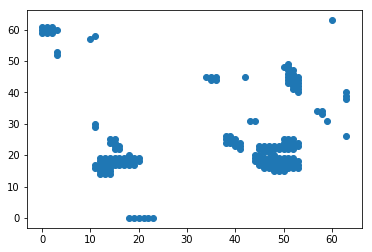

In [22]:
# Đưa các toạ độ về 64 x 64
featuresInSquare = np.array([[feature % 64, feature // 64] for feature in significantFeatures])
# Vẽ các toạ độ với matplotlib 
plt.scatter(featuresInSquare[:, 0], featuresInSquare[:, 1])

Chú ý rằng trong hình ảnh, toạ độ (0, 0) sẽ ứng với góc trên, bên trái, nên hình vẽ trên cần được đọc "ngược" từ dưới lên. Ta thấy một phần lớn vị trí các điểm quan trọng để nhận diện các ca sĩ nằm ở khu vực mắt-lông mày. (Đây là lí do ở phần trước ta chú trọng việc trích xuất mắt). Trong [2], phương pháp dùng toàn bộ khuôn mặt được gọi là *global approach*, phương pháp dùng một số thành phần của khuôn mặt được gọi là *component-based approach*.

## Phần 3 - Nhận diện ca sĩ

Đến giờ, bạn đã có công cụ để thực hiện việc train-test với một phần/toàn bộ dữ liệu. Hãy thực hiện các yêu cầu sau:

### Bài 16.
***Dùng SVM tuyến tính và một hay một số phương pháp classify khác đã biết (KNN, LDA, QDA, GNB, LogisticRegression) để train và tính score trên tập test để phân biệt:***
- *Một ca sĩ nam và một ca sĩ nữ: ví dụ BaoThy và DanTruong*
- *Hai ca sĩ nam: ví dụ DanTruong và LamTruong*
- *Hai ca sĩ nữ: ví dụ BaoThy và HuongTram*

***Với các phương pháp xác suất (LDA, QDA, GNB, LogisticRegression), tính ROC AUC trên tập test. Cặp ca sĩ nào cho kết quả tốt nhất, kém hơn?***

### Bài 17.
***Dùng SVM tuyến tính để train và tính score trên tập test để phân biệt một nhóm nhiều ca sĩ nhất có thể (tuỳ tốc độ máy của bạn, tốt nhất là toàn bộ 12 ca sĩ)***

### Bài 18.
***Dùng SVM tuyến tính để train và tính score trên tập test để phân biệt một nhóm nhiều ca sĩ, nhưng thay vì sử dụng dữ liệu của toàn bộ khuôn mặt thì chỉ sử dụng dữ liệu của đôi mắt. Kết quả tốt hay kém hơn so với bài 17?***

### Bài 19.
***Dùng SVM tuyến tính để train và tính score trên tập test để phân biệt một nhóm nhiều ca sĩ, nhưng thay vì sử dụng dữ liệu của đôi mắt thì chỉ sử dụng 1 mắt trái hoặc 1 mắt phải. Kết quả tốt hay kém hơn so với bài 18?***

Dưới đây là một cách thực hiện bài 18.

**Dùng toàn bộ khuôn mặt: 621 hình ảnh được đưa vào tập dữ liệu, sau khi huấn luyện nhận diện đúng 77.17%**

In [36]:
from itertools import chain
singers = ["BaoThy", "HuongTram", "DanTruong", "LamTruong"]
transformImagesToFacesTable(IMAGE_FOLDER, TEXT_DATA_FOLDER, "TextData/BaoThy_vs_HuongTram_vs_DanTruong_vs_LamTruong_Faces.csv", chain.from_iterable([SINGER_IMAGE_RANGE[s] for s in singers]))

10 files processed.
20 files processed.
30 files processed.
40 files processed.
50 files processed.
60 files processed.
70 files processed.
80 files processed.
90 files processed.
100 files processed.
110 files processed.
120 files processed.
130 files processed.
140 files processed.
150 files processed.
160 files processed.
170 files processed.
180 files processed.
190 files processed.
200 files processed.
210 files processed.
220 files processed.
230 files processed.
240 files processed.
250 files processed.
260 files processed.
270 files processed.
280 files processed.
290 files processed.
300 files processed.
310 files processed.
320 files processed.
330 files processed.
340 files processed.
350 files processed.
360 files processed.
370 files processed.
380 files processed.
390 files processed.
400 files processed.
410 files processed.
420 files processed.
430 files processed.
440 files processed.
450 files processed.
460 files processed.
470 files processed.
480 files processed.
4

In [32]:
dataSet = DataSet("TextData/BaoThy_vs_HuongTram_vs_DanTruong_vs_LamTruong_Faces.csv")
dataSet.X.shape # Xác định được 621 khuôn mặt

(621, 4096)

In [33]:
dataSet.trainTestSplit(test_size = 0.5)
myModel = SVC(kernel = "linear", decision_function_shape = "ovr")
dataSet.train(myModel)
dataSet.getConfusionMatrix(myModel)

array([[70,  2, 26,  7],
       [ 1, 53,  1,  7],
       [17,  1, 86,  2],
       [ 2,  4,  1, 31]], dtype=int64)

In [35]:
dataSet.score(myModel)

0.7717041800643086

**Dùng đôi mắt: 402 hình ảnh được đưa vào tập dữ liệu, được xem như có chất lượng tốt, sau khi huấn luyện nhận diện đúng 71.14%**

In [25]:

transformImagesToEyesTable(IMAGE_FOLDER, TEXT_DATA_FOLDER, "TextData/BaoThy_vs_HuongTram_vs_DanTruong_vs_LamTruong_Eyes.csv", chain.from_iterable([SINGER_IMAGE_RANGE[s] for s in singers]))

10 files processed.
20 files processed.
30 files processed.
40 files processed.
50 files processed.
60 files processed.
70 files processed.
80 files processed.
90 files processed.
100 files processed.
110 files processed.
120 files processed.
130 files processed.
140 files processed.
150 files processed.
160 files processed.
170 files processed.
180 files processed.
190 files processed.
200 files processed.
210 files processed.
220 files processed.
230 files processed.
240 files processed.
250 files processed.
260 files processed.
270 files processed.
280 files processed.
290 files processed.
300 files processed.
310 files processed.
320 files processed.
330 files processed.
340 files processed.
350 files processed.
360 files processed.
370 files processed.
380 files processed.
390 files processed.
400 files processed.
410 files processed.
420 files processed.
430 files processed.
440 files processed.
450 files processed.
460 files processed.
470 files processed.
480 files processed.
4

In [27]:
dataSet = DataSet("TextData/BaoThy_vs_HuongTram_vs_DanTruong_vs_LamTruong_Eyes.csv")
dataSet.X.shape # Chỉ xác định được 402 đôi mắt

(402, 2048)

In [28]:
dataSet.trainTestSplit(test_size = 0.5)
myModel = SVC(kernel = "linear", decision_function_shape = "ovr")
dataSet.train(myModel)
dataSet.getConfusionMatrix(myModel)

array([[45,  4, 18,  3],
       [ 8, 24,  1,  5],
       [12,  0, 59,  0],
       [ 4,  3,  0, 15]], dtype=int64)

In [29]:
dataSet.score(myModel)

0.7114427860696517

Như vậy chỉ với thành phần mắt không thay thế được cho toàn bộ khuôn mặt dù đã sử dụng data set chất lượng tốt.

## Tham khảo

[1] P.Jonathon Phillips, *Support Vector Machines Applied to Face Recognition, National Institute of standards and Technology* 

[2] Bernd Heisele, Purdy Ho, Tomaso Poggio, *Face Recognition with Support Vector Machines: Global versus Component-based Approach*, Masachusetts Institute of Technology, Center of Biological and Computational Learning

[3] https://drive.google.com/file/d/1szwAQHgXUR2vESBexosW0yJvvfKQfWnI/view - Link gốc dữ liệu của Thor Pham, chia sẻ trên blog Machine Learning cơ bản (https://www.facebook.com/groups/machinelearningcoban/permalink/458486681275411/)